# Modeling

## Some Questions to Ask
- Which model do we choose given the nature of our data?
- How do we set the parameters?
- How well can we predict the disease?
- Which features are important for prediction purposes?
- What is going on in the model?

In [1]:
import eli5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV

import util

%matplotlib inline

In [2]:
df = pd.read_csv(util.DATA_PATH_PREPROCESSED)
df.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,3,145,233,1,2,150,0,2.3,2,0,0,0
1,67,1,0,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,0,120,229,0,2,129,1,2.6,1,2,2,1
3,37,1,1,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,2,130,204,0,2,172,0,1.4,0,0,1,0


# First Pass

## Split Data into Train and Test

In [3]:
X = df[util.FEATURES].values
y = df[util.TARGET].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Train Model

In [5]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Assess Result

### Prediction Performance

How well can we predict the outcome?

In [6]:
yp_test = clf.predict(X_test)

In [7]:
util.confusion_matrix_as_df(y_test, yp_test, labels=util.TARGET_VALUES)

pred,No,Yes
true,,
No,31,20
Yes,13,36


### Feature Importance

Which features are important?

In [8]:
feature_importances = pd.DataFrame({'DecisionTree': clf.feature_importances_}, 
                                   index=pd.Series(util.FEATURES, name='feature'))
(feature_importances.sort_values('DecisionTree', ascending=False)
                    .style.bar().format('{:.2f}'))

,DecisionTree
feature,
ChestPain,0.26
Ca,0.12
Age,0.10
Slope,0.09
Chol,0.09
Sex,0.07
RestBP,0.07
MaxHR,0.06
Oldpeak,0.06


### Assess Model: Compare Train Test Scores

How well do training and test scores match? Are we over- or underfitting?

In [9]:
clf.score(X_train, y_train), clf.score(X_test, y_test)

(1.0, 0.67)

In [10]:
eli5.show_weights(clf, feature_names=util.FEATURES, target_names=util.TARGET_VALUES, filled=True)

Weight,Feature
0.2617,ChestPain
0.1197,Ca
0.0996,Age
0.0872,Slope
0.0855,Chol
0.0696,Sex
0.0693,RestBP
0.0625,MaxHR
0.0600,Oldpeak
0.0428,RestECG


## Supplements
- Explore Impact of Model Parameter Settings / Over- and Underfitting

### Assess Model: Exemplify Effect of `min_samples_leaf` Parameter

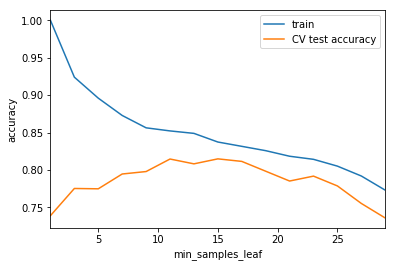

In [11]:
param_range = np.arange(1, 30, 2)
param_name = 'min_samples_leaf'

train_scores, valid_scores = validation_curve(
    DecisionTreeClassifier(), X, y, 
    param_name, param_range,
    cv=5,
)

fig, ax = plt.subplots()
ax.plot(param_range, train_scores.mean(axis=1), label='train')
ax.plot(param_range, valid_scores.mean(axis=1), label='CV test accuracy')
ax.set_xlim(left=param_range.min(), right=param_range.max())
ax.set_ylabel('accuracy')
ax.set_xlabel(param_name)
ax.legend()

## Perform Cross Validated Grid Search to Get Paremters Right

In [12]:
# this is a small search for demo purposes only
# consider performing stratified splits
param_grid = {'max_depth': [None, 5, 2, 1], 
              'min_samples_leaf': [1, 5, 10, 15]}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                              param_grid=param_grid, 
                              return_train_score=True, 
                              cv=5, refit=True)
grid_search_cv.fit(X, y)

/home/claus/miniconda3/envs/mlintro/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [None, 5, 2, 1], 'min_samples_leaf': [1, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [13]:
util.cv_results_to_df(grid_search_cv.cv_results_).style.highlight_max(subset=['mean_test_score'], axis=0)

,max_depth,min_samples_leaf,mean_test_score,mean_train_score
3,nan,15,0.811881,0.837441
7,5,15,0.811881,0.837441
2,nan,10,0.805281,0.854762
6,5,10,0.805281,0.854762
1,nan,5,0.768977,0.896044
5,5,5,0.765677,0.891932
4,5,1,0.762376,0.935618
8,2,1,0.755776,0.773107
9,2,5,0.755776,0.773107
10,2,10,0.755776,0.773107


In [14]:
eli5.show_weights(grid_search_cv.best_estimator_, feature_names=util.FEATURES, target_names=util.TARGET_VALUES, filled=True)

Weight,Feature
0.4776,ChestPain
0.1993,Thal
0.1670,Ca
0.0427,MaxHR
0.0415,Age
0.0402,Sex
0.0168,Slope
0.0138,Oldpeak
0.0012,Chol
0,RestECG


# Second Pass

Can we do better?

## Ask More Experts aka Use a RandomForest

Why not ask several experts and aggregate their opinion?

In [15]:
clf_rf = RandomForestClassifier(n_estimators=100, max_features=1, random_state=42)
clf_rf.fit(X_train, y_train)
yp_test_rf = clf_rf.predict(X_test)

display('Decision Tree')
display(util.confusion_matrix_as_df(y_test, yp_test))
display('Random Forest')
util.confusion_matrix_as_df(y_test, yp_test_rf)

'Decision Tree'

pred,0,1
true,,
0,31,20
1,13,36


'Random Forest'

pred,0,1
true,,
0,45,6
1,9,40


In [16]:
clf_rf.score(X_test, y_test)

0.85

In [17]:
feature_importances['RandomForest'] = clf_rf.feature_importances_

(feature_importances.sort_values('DecisionTree', ascending=False)
                    .style.bar().format('{:.2f}'))

,DecisionTree,RandomForest
feature,,
ChestPain,0.26,0.10
Ca,0.12,0.10
Age,0.10,0.11
Slope,0.09,0.06
Chol,0.09,0.10
Sex,0.07,0.05
RestBP,0.07,0.09
MaxHR,0.06,0.13
Oldpeak,0.06,0.10


## Possible Follow Up Questions
- Decision making under uncertainty (imprecise model predictions)?
- [Bias](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1796903/) in random forest variable importance.
- ...